In [1]:
import os.path
import zipfile

import numpy as np

from skimage import io as skimageio
from skimage import color as skimagecolor

import matplotlib.pyplot as plt

from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset

from torchsampler import ImbalancedDatasetSampler

c:\Users\tydta\.conda\envs\cie6004\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# hyperparameter
batch_size = 64
num_classes = 12
epochs = 50

In [3]:
# Env check
# check dataset file exists
dataset_path = 'garbage_classification.zip'
if not os.path.isfile(dataset_path):
    print("The dataset is not found. Please put it in the root of the directory and rename it as \"garbage_classification.zip\".")
    print("The link of the dataset is: https://drive.google.com/file/d/1kcwBy_yG47Mp2iyq6Oo6ACojgdXRt4Bs/view?usp=sharing")
    exit()

# extract the dataset
if not os.path.exists("garbage_classification/"):
    print("extracting the dataset... ")
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall("./")
print("The dataset has been extracted.")

The dataset has been extracted.


In [4]:
# Load dataset
train_path_file = "garbage_classification/train.txt"
test_path_file = "garbage_classification/test.txt"
val_path_file = "garbage_classification/val.txt"
# read path file
train_file_paths = []
test_file_paths = []
val_file_paths = []
with open(train_path_file) as file:
    train_file_paths = [line.rstrip() for line in file]
with open(test_path_file) as file:
    test_file_paths = [line.rstrip() for line in file]
with open(val_path_file) as file:
    val_file_paths = [line.rstrip() for line in file]
print("The size of train data: ",len(train_file_paths))
print("The size of test data: ",len(test_file_paths))
print("The size of val data: ",len(val_file_paths))



The size of train data:  9923
The size of test data:  3106
The size of val data:  2486


The dataset is read. Analyzing the dataset...
The minimal of width:  110
The minimal of height:  106
The maximal of width:  888
The maximal of width:  936
Here are some samples from the dataset: 


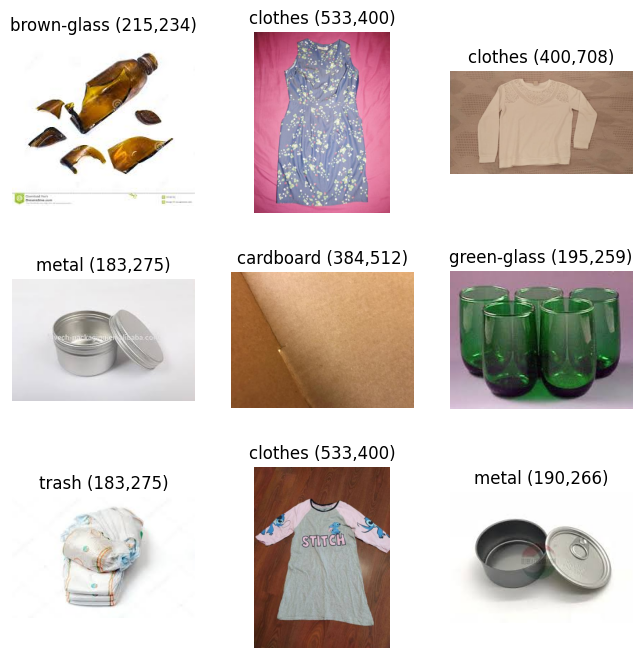

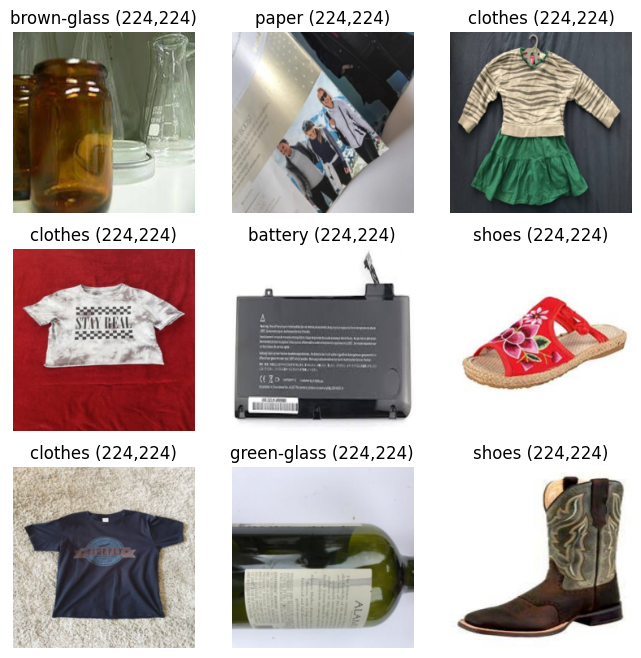

{'battery': 604, 'biological': 630, 'brown-glass': 388, 'cardboard': 569, 'clothes': 3408, 'green-glass': 402, 'metal': 492, 'paper': 672, 'plastic': 553, 'shoes': 1264, 'trash': 445, 'white-glass': 496}


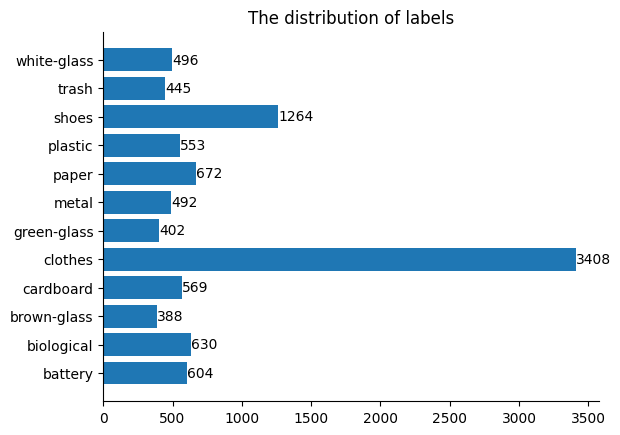

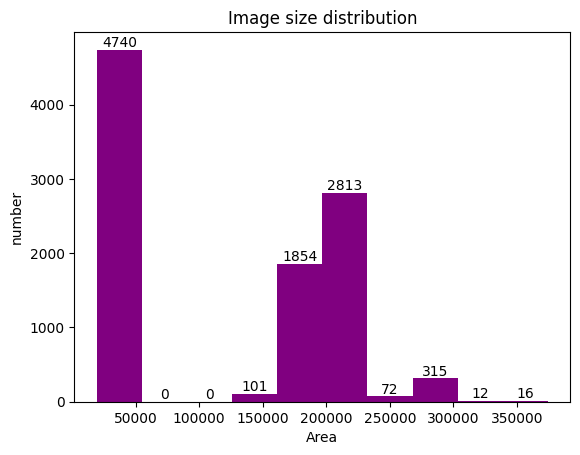

In [5]:
# Analyze dataset
print("The dataset is read. Analyzing the dataset...")
# read dataset
w_min = 100000
w_max = -1
h_min = 100000
h_max = -1
for path in train_file_paths:
    im = skimageio.imread(path)
    if h_min > im.shape[0]:
        h_min = im.shape[0]
    if w_min > im.shape[1]:
        w_min = im.shape[1]
    if h_max < im.shape[0]:
        h_max = im.shape[0]
    if w_max < im.shape[1]:
        w_max = im.shape[1]

print("The minimal of width: " , w_min)
print("The minimal of height: " , h_min)
print("The maximal of width: " , w_max)
print("The maximal of width: " , h_max)

# Pick up some samples from dataset
print("Here are some samples from the dataset: ")
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_file_paths), size=(1, )).item()
    img_path = train_file_paths[sample_idx]
    img_path = img_path.rstrip()
    label = img_path.split("/")[1]
    figure.add_subplot(rows, cols, i)
    img = Image.open(img_path).convert(
        "RGB"
    )  # 利用Image.open对图片进行读取，img类型为 Image ，mode=‘RGB’
    img_array = np.array(img)
    label = label + " (" + str(img_array.shape[0]) + ","+str(img_array.shape[1]) + ")"
    plt.title(label)
    plt.axis("off")
    plt.imshow(img)
plt.show()

# see image after transformers
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_file_paths), size=(1, )).item()
    img_path = train_file_paths[sample_idx]
    img_path = img_path.rstrip()
    label = img_path.split("/")[1]
    figure.add_subplot(rows, cols, i)
    origin_img = Image.open(img_path).convert(
        "RGB"
    )  # 利用Image.open对图片进行读取，img类型为 Image ，mode=‘RGB’
    img = transforms.Resize([224,224])(origin_img)
    # img = transforms.CenterCrop(224)(img)
    img_array = np.array(img)
    label = label + " (" + str(img_array.shape[0]) + ","+str(img_array.shape[1]) + ")"
    plt.title(label)
    plt.axis("off")
    plt.imshow(img)
plt.show()

# Show the distribution of labels
data = {
    "battery": 0,
    "biological": 0,
    "brown-glass": 0,
    "cardboard": 0,
    "clothes": 0,
    "green-glass": 0,
    "metal": 0,
    "paper": 0,
    "plastic": 0,
    "shoes": 0,
    "trash": 0,
    "white-glass": 0,
}
for path in train_file_paths:
    label = path.split("/")[1]
    data[label] = data[label] + 1
x = []
y = []
for item in data.items():
    x.append(item[0])
    y.append(item[1])
print(data)
plt.title("The distribution of labels")
bar = plt.barh(x,y)
plt.bar_label(bar, label_type='edge')
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# Show the distribution of the area of images, for better under stand the dataset
area_data = []
for path in train_file_paths:
    img = Image.open(path).convert("RGB")
    img_array = np.array(img)
    area_data.append(img_array.shape[0]*img_array.shape[1])
counts, edges, bars = plt.hist(area_data, color="purple")
# # 设置图表属性
plt.title('Image size distribution')
plt.xlabel('Area')
plt.ylabel('number')
plt.bar_label(bars)
# # 显示图表
plt.show()

In [6]:
# define dataloader

categories = {
    "battery": 0,
    "biological": 1,
    "brown-glass": 2,
    "cardboard": 3,
    "clothes": 4,
    "green-glass": 5,
    "metal": 6,
    "paper": 7,
    "plastic": 8,
    "shoes": 9,
    "trash": 10,
    "white-glass": 11,
}

data_transforms = {
    "train": transforms.Compose(
        [
            # data augmentation
            # transforms.RandomRotation(45),  # random rotation from -45 to 45 degrees
            # transforms.RandomHorizontalFlip(
            #     p=0.5
            # ),  # random rotation from probability p
            # transforms.RandomVerticalFlip(
            #     p=0.5
            # ),  # random vertical flip from probability p
            # transforms.ColorJitter(
            #     brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1
            # ),
            # transforms.RandomGrayscale(
            #     p=0.025
            # ),  # randomly transform color to grayscae, R=G=B for 3 channels
            # ritual transformation
            transforms.Resize([224,224]),
            # transforms.CenterCrop(224),  # center crop
            transforms.ToTensor(),
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "valid": transforms.Compose(
        [
            transforms.Resize([224,224]),
            # transforms.CenterCrop(224),  # center crop
            transforms.ToTensor(),
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}


class MyDataset(Dataset):
    def __init__(self, txt_path, transform=None, target_transform=None):
        fh = open(txt_path, "r")
        imgs = []
        labels = []
        for line in fh:
            line = line.rstrip()
            words = line.split("/")
            imgs.append((line, categories[words[1]]))
            labels.append(categories[words[1]])
            self.imgs = imgs
            self.labels = labels
            self.transform = transform
            self.target_transform = target_transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        fn, label = self.imgs[
            index
        ]  # self.imgs是一个list，self.imgs的一个元素是一个str，包含图片路径，图片标签，这些信息是在init函数中从txt文件中读取的
        img = Image.open(fn).convert(
            "RGB"
        )  # 利用Image.open对图片进行读取，img类型为 Image ，mode=‘RGB’
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def get_labels(self,):
        return self.labels


# Load dataset
train_path_file = "garbage_classification/train.txt"
val_path_file = "garbage_classification/val.txt"
test_path_file = "garbage_classification/test.txt"
train_data = MyDataset(
    txt_path=train_path_file, transform=data_transforms["train"]
)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_data = MyDataset(
    txt_path=val_path_file, transform=data_transforms["valid"]
)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)
test_data = MyDataset(
    txt_path=test_path_file, transform=data_transforms["valid"]
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [7]:
# 防止SSL报错
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

# define the model
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from einops.layers.torch import Rearrange
from tqdm import tqdm

# 数据加载和预处理
transform = transforms.Compose(
    [
        transforms.Resize((448, 448)),
        transforms.ToTensor(),
        # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

# train_dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

__all__ = ["ResNet", "resnet18", "resnet34", "resnet50", "resnet101", "resnet152"]

model_urls = {
    "resnet18": "https://download.pytorch.org/models/resnet18-5c106cde.pth",
    "resnet34": "https://download.pytorch.org/models/resnet34-333f7ec4.pth",
    "resnet50": "https://download.pytorch.org/models/resnet50-19c8e357.pth",
    "resnet101": "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth",
    "resnet152": "https://download.pytorch.org/models/resnet152-b121ed2d.pth",
}


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, 3, stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, input):
        residual = input
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.downsample:
            residual = self.downsample(residual)
        x += residual
        x = self.relu(x)
        return x


class BottleNeck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BottleNeck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, 3, stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(
            out_channels, out_channels * self.expansion, 1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, input):
        residual = input
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        if self.downsample:
            residual = self.downsample(residual)
        x += residual
        x = self.relu(x)
        return x


class Resnet(nn.Module):
    # 224*224
    def __init__(self, block, num_layer, n_classes=1000, input_channels=3):
        super(Resnet, self).__init__()
        self.adaptivePool = nn.AdaptiveAvgPool2d(224)
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, num_layer[0])
        self.layer2 = self._make_layer(block, 128, num_layer[1], 2)
        self.layer3 = self._make_layer(block, 256, num_layer[2], 2)
        self.layer4 = self._make_layer(block, 512, num_layer[3], 2)
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.fc = nn.Linear(block.expansion * 512, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)

    def _make_layer(self, block, out_channels, num_block, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    out_channels * block.expansion,
                    1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, num_block):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = Resnet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls["resnet18"]))
    return model

In [8]:
# 训练模型

def train(data_loader, model, epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    # train record
    loss_record = []
    acc_record = []
    # train process
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_acc_num = 0
        loop = tqdm(data_loader)
        for batch_idx, (data, target) in enumerate(loop):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = nn.CrossEntropyLoss()(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            # statistc
            _, preds = torch.max(output.data, 1)
            running_corrects = torch.sum(preds == target)
            batch_acc = running_corrects / len(preds)
            total_acc_num += running_corrects.cpu()
            # add stuff to progress bar in the end
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item(), acc=batch_acc.item())
        # record for each epoch
        loss_record.append(total_loss/len(data_loader))
        acc_record.append(total_acc_num/len(data_loader))
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(data_loader)}, Acc: {total_acc_num/len(data_loader)}")
    # save the model
    torch.save(model.state_dict(), 'vision_transformer_model.pth')
    return loss_record, acc_record


In [ ]:
# train the model
model = Resnet(BasicBlock, [2, 2, 2, 2], n_classes=num_classes)

# train record
loss_record, acc_record = train(train_loader, model, epochs=50)

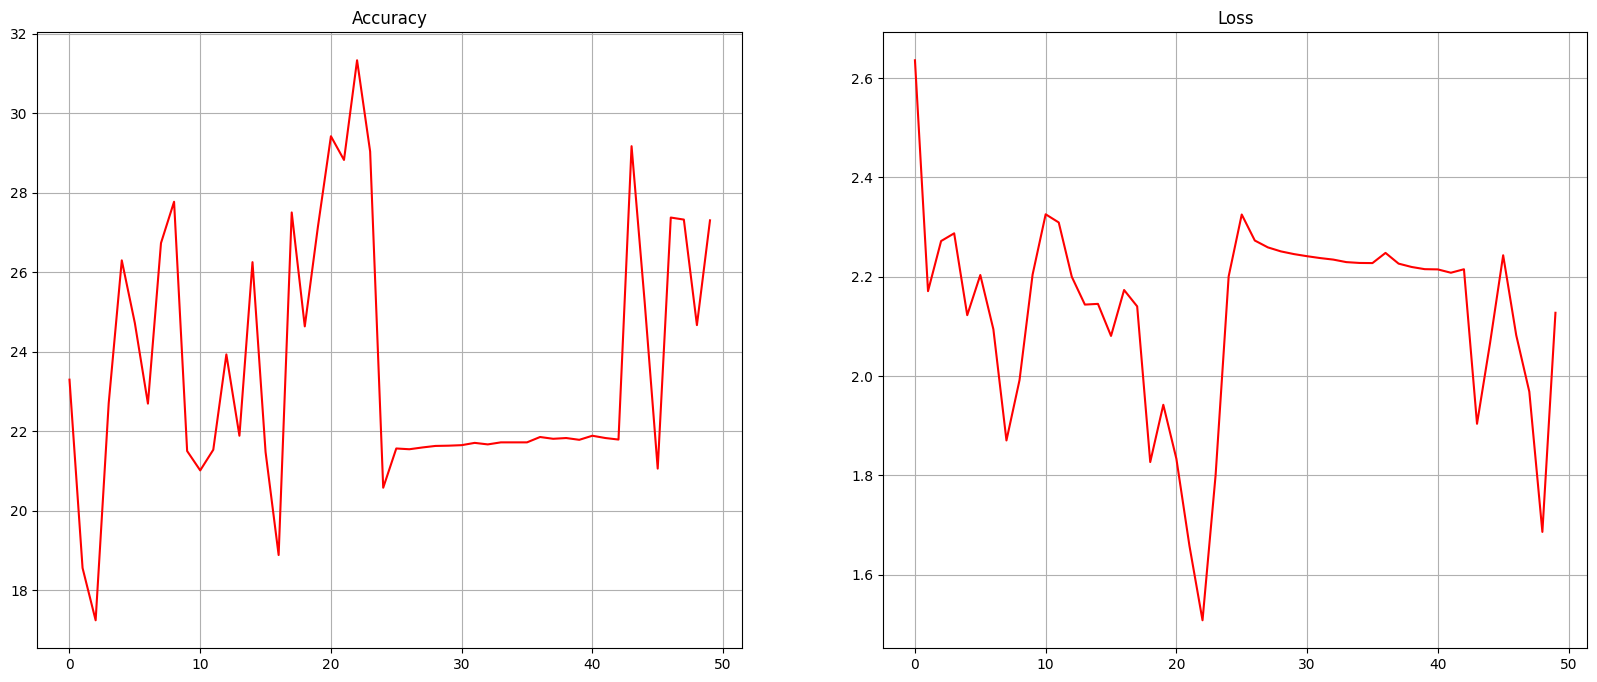

In [9]:
# plot
fig = plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.title("Accuracy")
plt.plot(acc_record, 'r')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title("Loss")
plt.plot(loss_record, 'r')
plt.grid(True)
plt.show()

9.251810136765888
Test Accuracy of the model on the 39 test images: 9.251810136765888 %
Accuracy: 9.25
Precision: 0.09
Recall: 0.09
F1 Score: 0.09


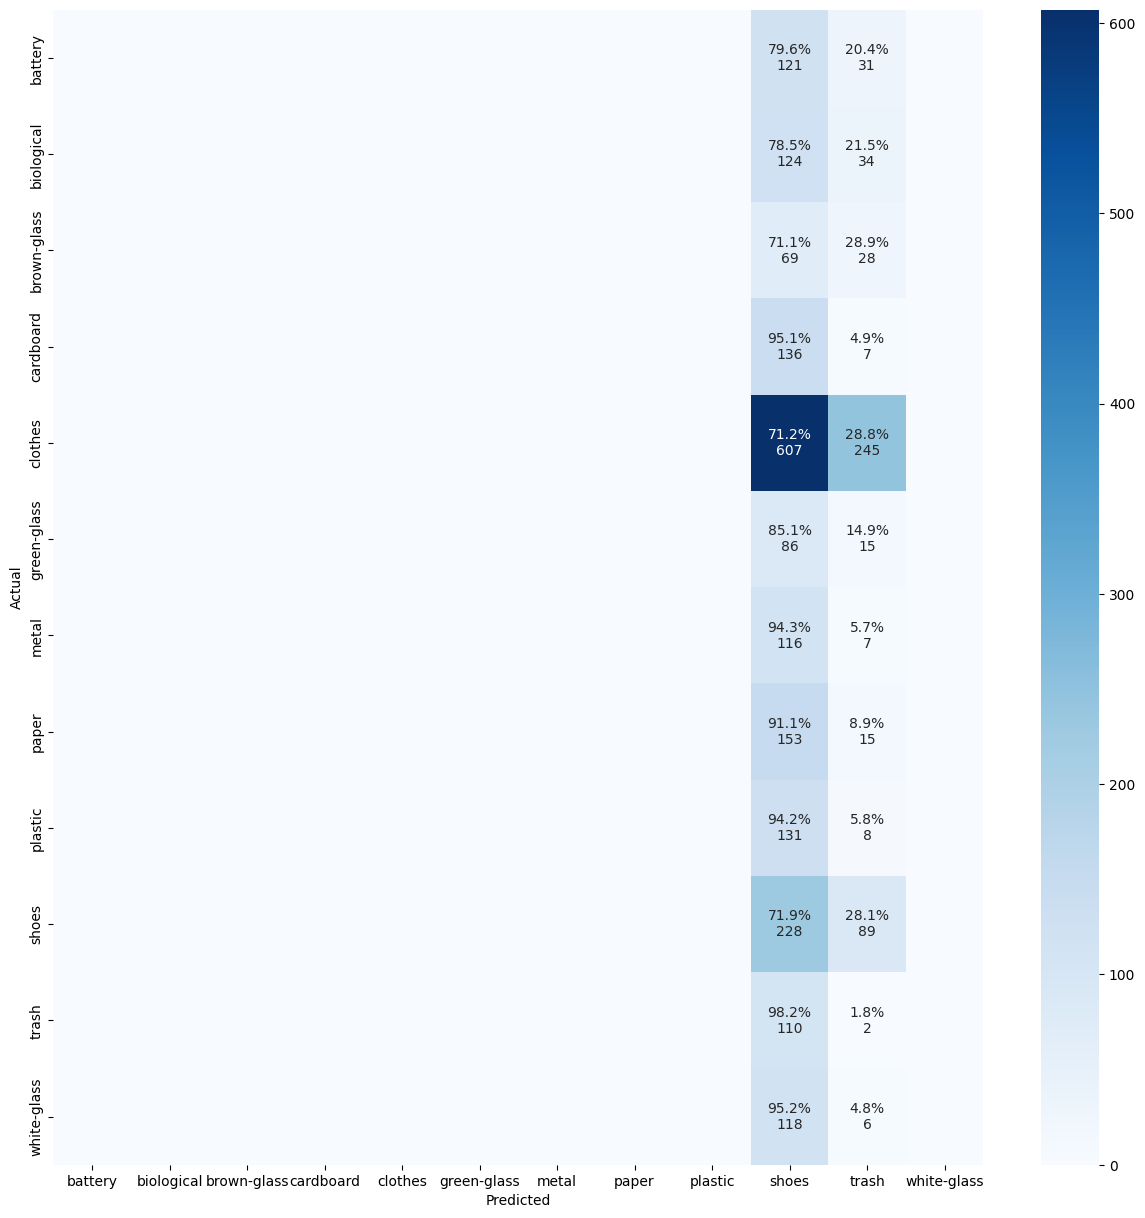

In [18]:
# test the model
import sklearn.metrics as sm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns

def valid(data_loader, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)with torch.no_grad():
    correct = 0
    total = 0
    targets, preds = [], []
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
        targets += list(labels.cpu().numpy())
        preds += list(pred.cpu().numpy())
    test_acc = 100 * correct / total
    print(test_acc)
    confusion_mtx = sm.confusion_matrix(targets, preds)
    precision = precision_score(targets, preds, average='micro')
    recall = recall_score(targets, preds, average='micro')
    f1 = f1_score(targets, preds, average='micro')
    return test_acc,precision,recall,f1, confusion_mtx


def vis(confusion_mtx, labels,figsize=(15, 15)):
    cm = confusion_mtx
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ""
            else:
                annot[i, j] = "%.1f%%\n%d" % (p,c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = "Actual"
    cm.columns.name = "Predicted"
    fig = plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt="", cmap="Blues")
    plt.show()

In [ ]:
accuracy,precision,recall,f1, confusion_mtx = valid(valid_loader, model)
print("Test Accuracy of the model on the {} test images: {} %".format(len(valid_loader), accuracy))
# 打印结果
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
vis(confusion_mtx, list(categories.keys()))

# The first optimization

In [26]:
torch.cuda.empty_cache()

In [9]:
# create a new dataloader with balance sampler
train_loader_update_1 = torch.utils.data.DataLoader(train_data, sampler=ImbalancedDatasetSampler(train_data),batch_size=batch_size)
# train the model
num_classes = 12
epochs = 50
model = Resnet(BasicBlock, [2, 2, 2, 2], n_classes=num_classes)
loss_record, acc_record = train(train_loader_update_1, model, epochs=50)


Epoch [1/50]: 100%|██████████| 156/156 [00:38<00:00,  4.07it/s, acc=0.333, loss=2.08]


Epoch 1/50, Loss: 1.5441451126184218, Acc: 30.564102172851562


Epoch [2/50]: 100%|██████████| 156/156 [00:36<00:00,  4.24it/s, acc=0.333, loss=1.4]  


Epoch 2/50, Loss: 1.2634106408327053, Acc: 36.17307662963867


Epoch [3/50]: 100%|██████████| 156/156 [00:30<00:00,  5.17it/s, acc=0.333, loss=1.02] 


Epoch 3/50, Loss: 1.08931657519096, Acc: 40.49359130859375


Epoch [4/50]: 100%|██████████| 156/156 [00:30<00:00,  5.20it/s, acc=0.333, loss=2.6]  


Epoch 4/50, Loss: 0.9916702722891783, Acc: 43.02564239501953


Epoch [5/50]: 100%|██████████| 156/156 [00:30<00:00,  5.20it/s, acc=0, loss=2.42]     


Epoch 5/50, Loss: 0.9590690262042559, Acc: 43.512821197509766


Epoch [6/50]: 100%|██████████| 156/156 [00:29<00:00,  5.21it/s, acc=0.667, loss=1.18] 


Epoch 6/50, Loss: 0.8748824558196924, Acc: 45.21794891357422


Epoch [7/50]: 100%|██████████| 156/156 [00:30<00:00,  5.20it/s, acc=0, loss=4.33]     


Epoch 7/50, Loss: 0.8331948230281855, Acc: 46.35256576538086


Epoch [8/50]: 100%|██████████| 156/156 [00:29<00:00,  5.21it/s, acc=0.333, loss=2.68] 


Epoch 8/50, Loss: 0.8255661848263863, Acc: 46.32051467895508


Epoch [9/50]: 100%|██████████| 156/156 [00:30<00:00,  5.19it/s, acc=0.667, loss=1.71] 


Epoch 9/50, Loss: 0.7309911472675128, Acc: 48.45512771606445


Epoch [10/50]: 100%|██████████| 156/156 [00:30<00:00,  5.17it/s, acc=1, loss=0.32]     


Epoch 10/50, Loss: 0.6284857812600259, Acc: 50.18589782714844


Epoch [11/50]: 100%|██████████| 156/156 [00:30<00:00,  5.04it/s, acc=0.667, loss=0.809]


Epoch 11/50, Loss: 0.5407758334126228, Acc: 52.13461685180664


Epoch [12/50]: 100%|██████████| 156/156 [00:30<00:00,  5.10it/s, acc=0.333, loss=2.57] 


Epoch 12/50, Loss: 0.4978045252844309, Acc: 53.17307662963867


Epoch [13/50]: 100%|██████████| 156/156 [00:30<00:00,  5.07it/s, acc=0.667, loss=0.988]


Epoch 13/50, Loss: 0.4557400002884559, Acc: 53.95512771606445


Epoch [14/50]: 100%|██████████| 156/156 [00:30<00:00,  5.06it/s, acc=0.667, loss=1.98] 


Epoch 14/50, Loss: 0.4432652991456099, Acc: 54.4487190246582


Epoch [15/50]: 100%|██████████| 156/156 [00:30<00:00,  5.08it/s, acc=0.667, loss=1.41] 


Epoch 15/50, Loss: 0.4056367867459089, Acc: 55.39743423461914


Epoch [16/50]: 100%|██████████| 156/156 [00:30<00:00,  5.05it/s, acc=0.333, loss=0.947] 


Epoch 16/50, Loss: 0.3476589618680569, Acc: 56.80769348144531


Epoch [17/50]: 100%|██████████| 156/156 [00:30<00:00,  5.07it/s, acc=0.333, loss=1.11]  


Epoch 17/50, Loss: 0.277526440910804, Acc: 58.02564239501953


Epoch [18/50]: 100%|██████████| 156/156 [00:30<00:00,  5.07it/s, acc=0.667, loss=1.18]  


Epoch 18/50, Loss: 0.2518021726550964, Acc: 58.589744567871094


Epoch [19/50]: 100%|██████████| 156/156 [00:30<00:00,  5.09it/s, acc=0.333, loss=3.33]  


Epoch 19/50, Loss: 0.22925727458622974, Acc: 59.21794891357422


Epoch [20/50]: 100%|██████████| 156/156 [00:31<00:00,  5.02it/s, acc=0.333, loss=1.64]  


Epoch 20/50, Loss: 0.3064696221397473, Acc: 57.621795654296875


Epoch [21/50]: 100%|██████████| 156/156 [00:33<00:00,  4.72it/s, acc=1, loss=0.307]     


Epoch 21/50, Loss: 0.2199957714869808, Acc: 59.10256576538086


Epoch [22/50]: 100%|██████████| 156/156 [00:48<00:00,  3.22it/s, acc=0.667, loss=0.901] 


Epoch 22/50, Loss: 0.1531247451590995, Acc: 60.480770111083984


Epoch [23/50]: 100%|██████████| 156/156 [00:41<00:00,  3.75it/s, acc=1, loss=0.0685]    


Epoch 23/50, Loss: 0.15553852084737557, Acc: 60.46794891357422


Epoch [24/50]: 100%|██████████| 156/156 [00:38<00:00,  4.07it/s, acc=0.333, loss=1.11]  


Epoch 24/50, Loss: 0.07456958739278026, Acc: 62.36538314819336


Epoch [25/50]: 100%|██████████| 156/156 [00:32<00:00,  4.77it/s, acc=0.667, loss=1.7]   


Epoch 25/50, Loss: 0.1767484162790844, Acc: 60.160255432128906


Epoch [26/50]: 100%|██████████| 156/156 [00:30<00:00,  5.11it/s, acc=1, loss=0.284]     


Epoch 26/50, Loss: 0.14039159439599666, Acc: 60.92307662963867


Epoch [27/50]: 100%|██████████| 156/156 [00:30<00:00,  5.06it/s, acc=1, loss=0.475]     


Epoch 27/50, Loss: 0.07536257224348493, Acc: 62.21154022216797


Epoch [28/50]:  49%|████▉     | 77/156 [00:16<00:16,  4.66it/s, acc=0.969, loss=0.0827]

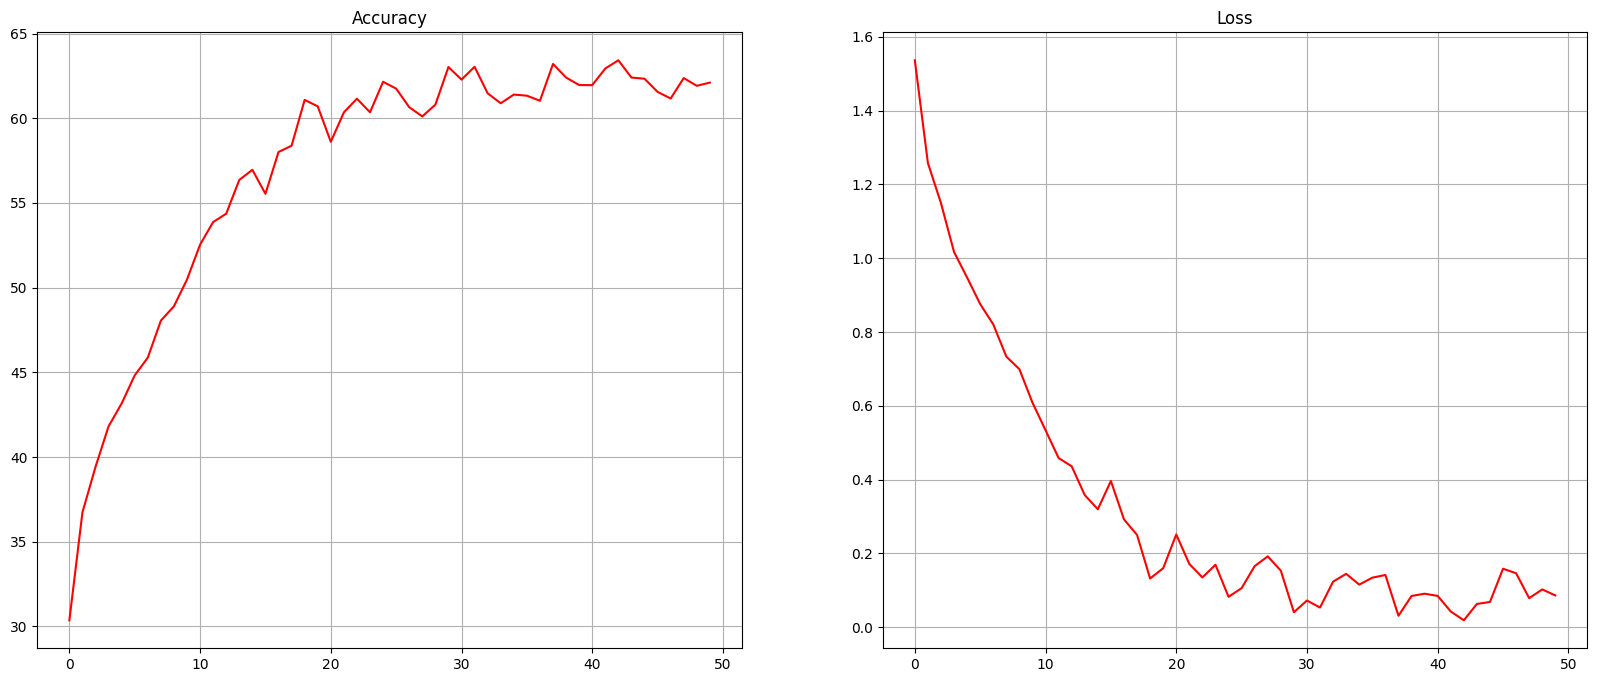

In [ ]:
# plot
fig = plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.title("Accuracy")
plt.plot(acc_record, 'r')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title("Loss")
plt.plot(loss_record, 'r')
plt.grid(True)
plt.show()

In [ ]:
# valid the new model
test_acc, confusion_mtx = valid(valid_loader, model_update_1)
print("Test Accuracy of the model on the {} test images: {} %".format(len(valid_loader), test_acc))
vis(confusion_mtx, list(categories.keys()))